In [1]:
!pip install nltk==3.6.5
!pip install sklearn==0.0

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, pow
from pyspark.sql.types import StringType
import string
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from pyspark.sql.functions import percent_rank
from pyspark.sql import Window
from pyspark.ml.feature import CountVectorizer, IDF, Tokenizer

In [3]:
spark = SparkSession \
    .builder \
    .getOrCreate()
print(spark)

Ivy Default Cache set to: /home/jovyan/.ivy2/cache
The jars for the packages stored in: /home/jovyan/.ivy2/jars
org.mongodb.spark#mongo-spark-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-7d7dfe0e-cd7a-48eb-abea-46ab2b9a3a28;1.0
	confs: [default]


:: loading settings :: url = jar:file:/usr/local/spark-3.2.0-bin-hadoop3.2/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found org.mongodb.spark#mongo-spark-connector_2.12;3.0.1 in central
	found org.mongodb#mongodb-driver-sync;4.0.5 in central
	found org.mongodb#bson;4.0.5 in central
	found org.mongodb#mongodb-driver-core;4.0.5 in central
:: resolution report :: resolve 180ms :: artifacts dl 9ms
	:: modules in use:
	org.mongodb#bson;4.0.5 from central in [default]
	org.mongodb#mongodb-driver-core;4.0.5 from central in [default]
	org.mongodb#mongodb-driver-sync;4.0.5 from central in [default]
	org.mongodb.spark#mongo-spark-connector_2.12;3.0.1 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   4   |   0   |   0   |   0   ||   4   |   0   |
	---------------------------------------------------------------------
:: retrieving ::

In [4]:
crypto_df = spark.read.format("mongo").option("uri","mongodb://mongo/seng550.crypto").load()
headers_df = spark.read.format("mongo").option("uri","mongodb://mongo/seng550.headers").load()

In [5]:
crypto_df.show(3)

+--------------------+------------------+----------+-----------------+
|                 _id|             close|      date|             open|
+--------------------+------------------+----------+-----------------+
|{619f20a05fec62ac...|        61238.6222|2021-10-23|60690.28731420007|
|{619f20a15fec62ac...| 60694.00000650834|2021-10-22|62196.96438572152|
|{619f20a15fec62ac...|62298.093007718286|2021-10-21|65961.04976056097|
+--------------------+------------------+----------+-----------------+
only showing top 3 rows



In [6]:
headers_df.show(3)

+--------------------+----------+--------------------+
|                 _id|      date|            headline|
+--------------------+----------+--------------------+
|{619f1214b82509cf...|2021-08-01|Family speaks out...|
|{619f1215b82509cf...|2021-08-01|China invasion of...|
|{619f1215b82509cf...|2021-08-01|US digital paymen...|
+--------------------+----------+--------------------+
only showing top 3 rows



In [7]:
crypto_df = crypto_df.withColumn('change', 1.0 - (col('close') / col('open')))
crypto_df.show(3)

+--------------------+------------------+----------+-----------------+--------------------+
|                 _id|             close|      date|             open|              change|
+--------------------+------------------+----------+-----------------+--------------------+
|{619f20a05fec62ac...|        61238.6222|2021-10-23|60690.28731420007|-0.00903496935120...|
|{619f20a15fec62ac...| 60694.00000650834|2021-10-22|62196.96438572152| 0.02416459378776714|
|{619f20a15fec62ac...|62298.093007718286|2021-10-21|65961.04976056097| 0.05553211730467056|
+--------------------+------------------+----------+-----------------+--------------------+
only showing top 3 rows



In [8]:
def clean_header(header):
    # Headers are small, so local process is ok.
    porter = PorterStemmer()
    header = header.strip()
    if not header:
        return ''
    header = header.translate(str.maketrans('', '', string.punctuation))
    return ' '.join(porter.stem(word) for word in header.split() if word not in ENGLISH_STOP_WORDS)

udf_clean_header = udf(lambda s: clean_header(s), StringType())
headers_df = headers_df.withColumn('headline_clean', udf_clean_header(col('headline')))
headers_df.show(3)

+--------------------+----------+--------------------+--------------------+
|                 _id|      date|            headline|      headline_clean|
+--------------------+----------+--------------------+--------------------+
|{619f1214b82509cf...|2021-08-01|Family speaks out...|famili speak raci...|
|{619f1215b82509cf...|2021-08-01|China invasion of...|china invas taiwa...|
|{619f1215b82509cf...|2021-08-01|US digital paymen...|us digit payment ...|
+--------------------+----------+--------------------+--------------------+
only showing top 3 rows



In [9]:
date_count_df = headers_df.groupby('date').count()
crypto_headline_df = crypto_df.join(headers_df, on='date')\
    .join(date_count_df.withColumnRenamed('count', 'date_count'), on='date')\
    .withColumn('change_normalized', pow(1 + col('change'), 1 / col('date_count')) - 1)\
    .select('date', 'headline_clean', 'change_normalized')
crypto_headline_df.show(3)

+----------+--------------------+--------------------+
|      date|      headline_clean|   change_normalized|
+----------+--------------------+--------------------+
|2021-04-06|asian share eas t...|0.001684018790797...|
|2021-04-06|patient wale uk r...|0.001684018790797...|
|2021-04-06|dubai model dodg ...|0.001684018790797...|
+----------+--------------------+--------------------+
only showing top 3 rows



In [10]:
# method 1 https://stackoverflow.com/a/51773836, can only be done on 1 partition

# assign ranks
# TODO better method to avoid this problem - if we do random splits it might be better? 
split_rank_df = crypto_headline_df\
    .withColumn("rank", percent_rank().over(Window.partitionBy().orderBy("date")))\
    .drop('date')\
    .cache()
# split
# X_train = df.where("rank <= .8").drop("rank","change")
# X_train.show()
# X_test = df.where("rank > .8").drop("rank","change")
# X_test.show()
# y_train = df.where("rank <= .8").drop("rank","clean_headline")
# y_train.show()
# y_test = df.where("rank > .8").drop("rank","clean_headline")
# y_test.show()
train_df = split_rank_df.where("rank <= .8").drop("rank")
train_df.show(3)
test_df = split_rank_df.where("rank > .8").drop("rank")
test_df.show(3)

# method 2 https://stackoverflow.com/a/53193549, needs the number of dates fed in to split
# from pyspark.ml.feature import StringIndexer

# stringIndexer = StringIndexer(inputCol="date", outputCol="index")
# model = stringIndexer.fit(headers_df)
# headers_df = model.transform(headers_df).withColumn("index", col("index").cast("int"))

# headers_df.show()

21/12/18 18:17:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+--------------------+--------------------+
|      headline_clean|   change_normalized|
+--------------------+--------------------+
|black amazon exec...|-0.01032963207099...|
|jeff bezo versu m...|-0.01032963207099...|
|michael gudinski ...|-0.01032963207099...|
+--------------------+--------------------+
only showing top 3 rows

+--------------------+--------------------+
|      headline_clean|   change_normalized|
+--------------------+--------------------+
|britney spears’ d...|0.010478678604092906|
|leylah fernandez ...|0.010478678604092906|
|taliban air scatt...|0.010478678604092906|
+--------------------+--------------------+
only showing top 3 rows



In [11]:
class TfidfModel:
    def __init__(self, tokenizer, cv_model, idf_model):
        self.tokenizer = tokenizer
        self.cv_model = cv_model
        self.idf_model = idf_model

tfidf_comp_prefix = 'kfwsxy'

def fit_tfidf_model(df, input_col, output_col):
    tokenizer = Tokenizer(inputCol=input_col, outputCol=f'{tfidf_comp_prefix}_words')
    words_data = tokenizer.transform(df)

    cv = CountVectorizer(inputCol=f'{tfidf_comp_prefix}_words', outputCol=f'{tfidf_comp_prefix}_raw')
    cv_model = cv.fit(words_data)

    featurized_data = cv_model.transform(words_data)

    idf = IDF(inputCol=f'{tfidf_comp_prefix}_raw', outputCol=output_col)
    idf_model = idf.fit(featurized_data)

    return TfidfModel(tokenizer, cv_model, idf_model)

tfidf_model = fit_tfidf_model(train_df, 'headline_clean', 'headline_features')

In [12]:
def tfidf_vectorize(df, tfidf_model):
    words_data = tfidf_model.tokenizer.transform(df)
    featurized_data = tfidf_model.cv_model.transform(words_data)
    res_df = tfidf_model.idf_model.transform(featurized_data)
    return res_df\
        .drop(f'{tfidf_comp_prefix}_words')\
        .drop(f'{tfidf_comp_prefix}_raw').drop('headline_clean')

vectorized_train_df = tfidf_vectorize(train_df, tfidf_model)
vectorized_test_df = tfidf_vectorize(test_df, tfidf_model)

vectorized_train_df.show(3)
vectorized_test_df.show(3)

+--------------------+--------------------+
|   change_normalized|   headline_features|
+--------------------+--------------------+
|-0.01032963207099...|(5604,[229,253,27...|
|-0.01032963207099...|(5604,[169,843,92...|
|-0.01032963207099...|(5604,[24,156,228...|
+--------------------+--------------------+
only showing top 3 rows

+--------------------+--------------------+
|   change_normalized|   headline_features|
+--------------------+--------------------+
|0.010478678604092906|(5604,[150,221,38...|
|0.010478678604092906|(5604,[7,49,78,15...|
|0.010478678604092906|(5604,[142,187,27...|
+--------------------+--------------------+
only showing top 3 rows



In [13]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression()
lr.setFeaturesCol("headline_features")
lr.setLabelCol("change_normalized")
model = lr.fit(vectorized_train_df)


21/12/18 18:17:50 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
21/12/18 18:17:50 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
21/12/18 18:17:50 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
21/12/18 18:17:50 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [14]:
summary = model.evaluate(vectorized_train_df)
mae = summary.meanAbsoluteError
rmse = summary.rootMeanSquaredError
print(f'Training results: MAE:{mae:.5f} rMSE:{rmse:.5f}')
summary = model.evaluate(vectorized_test_df)
mae = summary.meanAbsoluteError
rmse = summary.rootMeanSquaredError
print(f'Test results: MAE:{mae:.5f} rMSE:{rmse:.5f}')

Training results: MAE:0.00001 rMSE:0.00010
Test results: MAE:0.00416 rMSE:0.00534


In [15]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np

featuresCol='headline_features'
labelCol='change_normalized'

regParams = np.linspace(1000,3000,101)

lr = LinearRegression(
    elasticNetParam=0,
    featuresCol=featuresCol,
    labelCol=labelCol)

pipeline = Pipeline(stages=[lr])

paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, regParams)\
    .build()

evaluator = RegressionEvaluator(labelCol=labelCol)

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=4,
                          parallelism=8)

cvModel = crossval.fit(vectorized_train_df)

prediction = cvModel.transform(vectorized_test_df)

21/12/18 18:17:56 WARN BlockManager: Asked to remove block broadcast_311, which does not exist
21/12/18 18:18:03 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search zoom failed
21/12/18 18:18:03 ERROR LBFGS: Failure again! Giving up and returning. Maybe the objective is just poorly behaved?
21/12/18 18:18:03 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search zoom failed
21/12/18 18:18:04 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search zoom failed
21/12/18 18:18:05 ERROR LBFGS: Failure again! Giving up and returning. Maybe the objective is just poorly behaved?
21/12/18 18:18:05 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search zoom failed
21/12/18 18:18:05 ERROR LBFGS: Failure again! Giving up and returning. Maybe the objective is just poorly behaved?
21/12/18 18:18:05 ERROR LBFGS: Failure! Resetting history: breeze.optimize.First

In [16]:
prediction.show(3)

+--------------------+--------------------+--------------------+
|   change_normalized|   headline_features|          prediction|
+--------------------+--------------------+--------------------+
|0.010478678604092906|(5604,[150,221,38...|-2.47418694429240...|
|0.010478678604092906|(5604,[7,49,78,15...|-2.47360869497923...|
|0.010478678604092906|(5604,[142,187,27...|-2.47407047809980...|
+--------------------+--------------------+--------------------+
only showing top 3 rows



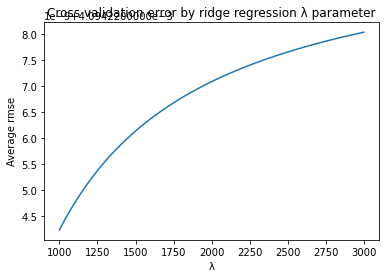

In [17]:
import pandas as pd
x_label = 'λ'
y_label = 'Average ' + evaluator.getMetricName()
tune_result_df = pd.DataFrame({
    x_label: regParams,
    y_label: cvModel.avgMetrics})\
    .set_index(['λ'])
plot = tune_result_df.plot.line(
    title='Cross validation error by ridge regression λ parameter',
    ylabel=y_label,
    legend=False)